# Multi-View Geometry

# Structure from Motion 

### Loading two camera views and camera's intrinsic matrix $K$ 

<IPython.core.display.Javascript object>


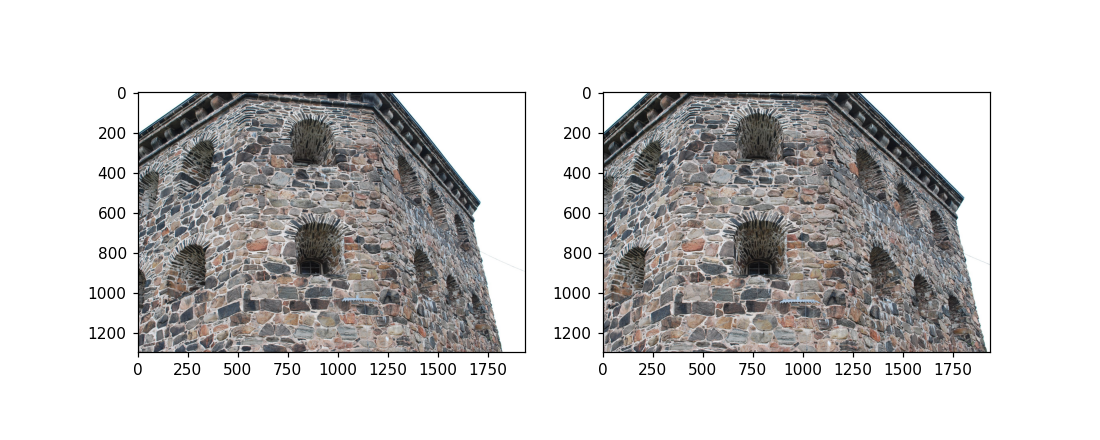

In [1]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, EssentialMatrixTransform, FundamentalMatrixTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/kronan1.jpg")
imR = image.imread("images/kronan2.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

K = 1.0e+03 * np.array([[2.3940, -0.0000,    0.9324],
                        [     0,  2.3981,    0.6283],
                        [     0,       0,    0.0010]])


plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

### Feature detection (e.g. corners) 

the number of features in images 1 and 2 are  1576 and  1661


<IPython.core.display.Javascript object>


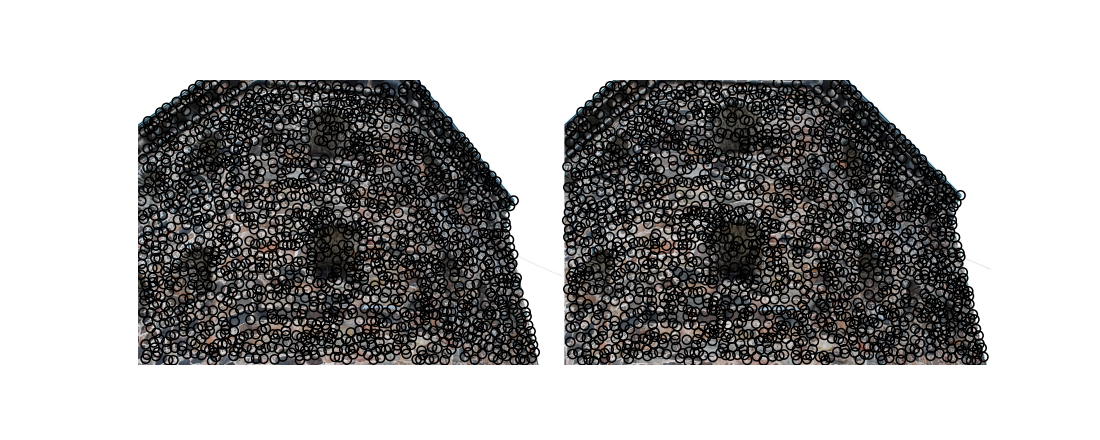

In [2]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.001, min_distance=15)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.001, min_distance=15)


print ('the number of features in images 1 and 2 are {:5d} and {:5d}'.format(keypointsL.shape[0],keypointsR.shape[0]))

fig = plt.figure(1,figsize = (10, 4))
axA = plt.subplot(111)
plt.gray()
matchesLR = np.empty((0,2))
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR)
axA.axis('off')

plt.show()

### Feature matching (e.g. BRIEF descriptor, a variant of SURF, SIFT, etc)

the number of matches is 982


<IPython.core.display.Javascript object>


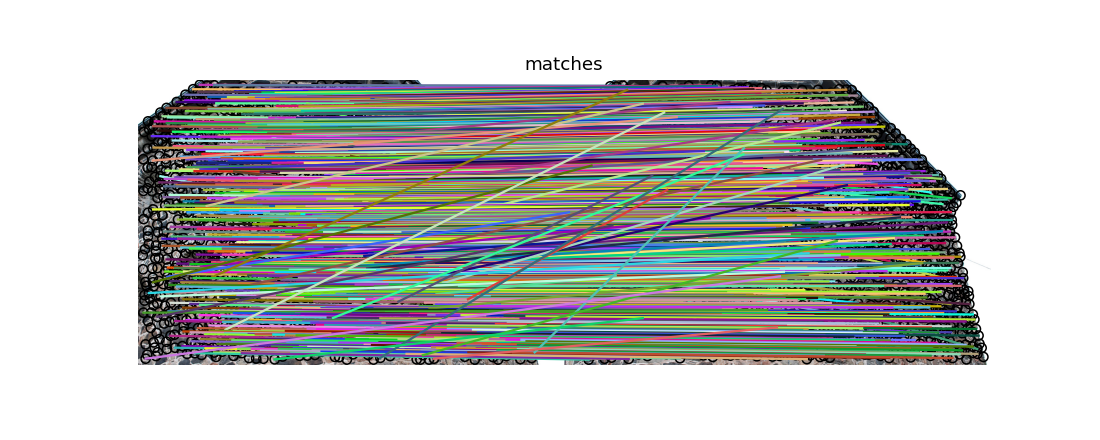

In [3]:
extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(2,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

### Fundamental Matrix estimation using RANSAC

the number of inliers is 197


<IPython.core.display.Javascript object>


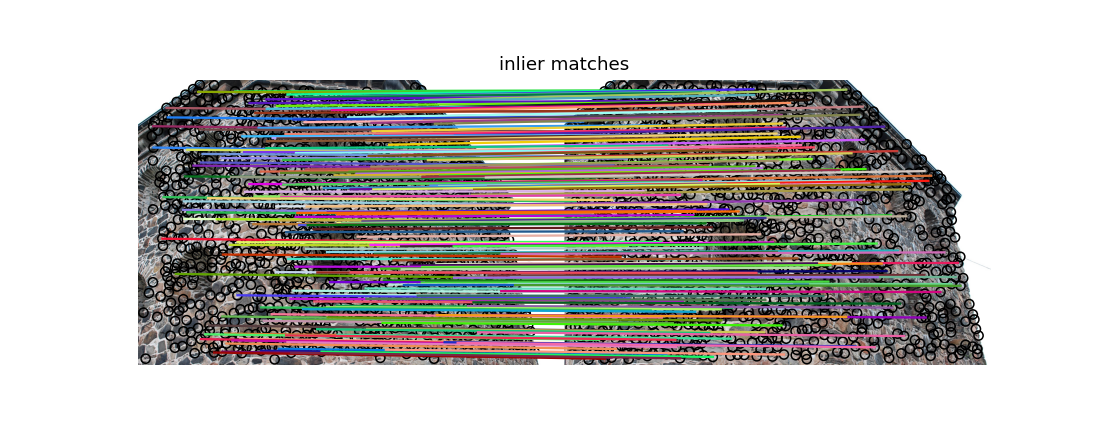

In [4]:
ptsL1 = []
ptsR1 = []
for i in matchesLR:
    ptsL1.append(keypointsL[i[0]])
    ptsR1.append(keypointsR[i[1]])
ptsL1 = np.array(ptsL1)
ptsR1 = np.array(ptsR1)

# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL = ptsL1[:,[1, 0]]
ptsR = ptsR1[:,[1, 0]]

# robustly estimate fundamental matrix using RANSAC
F_trans, F_inliers = ransac((ptsL, ptsR), FundamentalMatrixTransform, min_samples=8, residual_threshold=0.1, max_trials=1500)
print ('the number of inliers is {:2d}'.format(np.sum(F_inliers)))

ind = np.ogrid[:ptsL.shape[0]]
FmatchesRansac = np.column_stack((ind[F_inliers],ind[F_inliers]))

fig = plt.figure(3,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, FmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()

### singular values for F

In [5]:
F = F_trans.params
Uf,Sf,Vf = la.svd(F, full_matrices=False)
print (Sf)

[7.31785781e-02 5.76280993e-05 2.51685040e-19]


### Epipolar lines from F

<IPython.core.display.Javascript object>


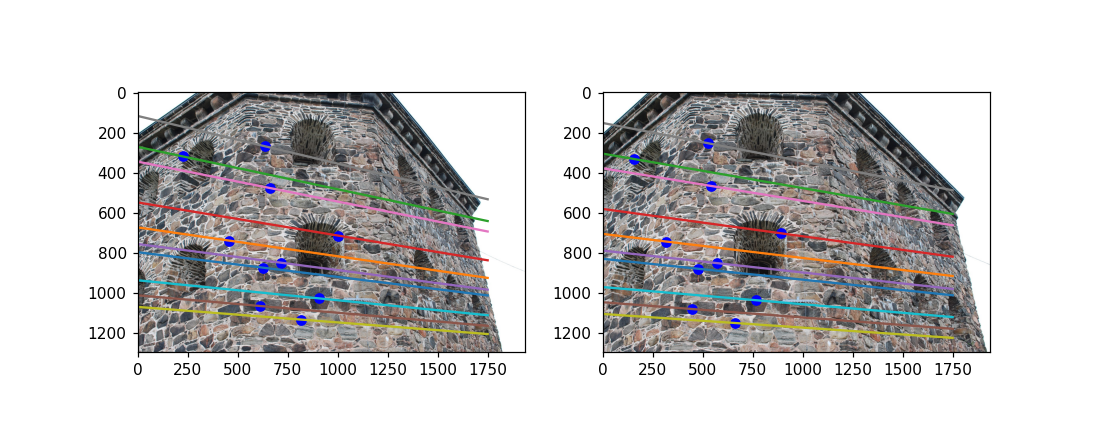

In [20]:
# Randomly select 10 matches (paris of features in two images) from the set of inliers for F
ind_sample = np.random.choice(ind[F_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(4,figsize = (10, 4))
ax41 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax42 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# generate epipolar line equations in image 2 (homoheneous 3-vectors l2 representing lines l2 x  = 0) 
# a. create an array of points sampled in images 1 and 2  
sample_1 = ptsL[ind_sample]
sample_2 = ptsR[ind_sample]
one = np.ones(10)

# b. create an array of homogeneous points sampled in images 1 and 2
sample1_homo = np.dstack((ptsL[ind_sample, 0],ptsL[ind_sample, 1],one))[0]
sample2_homo = np.dstack((ptsR[ind_sample, 0],ptsR[ind_sample, 1],one))[0]

# c. create an array of the corresponding epipolar lines in images 1 and 2 


elines1 = sample2_homo @ F
#print(elines1)
elines2 = elines1.copy()
for i in range(10):
    elines2[i] = F @ sample1_homo[i]
    #elines1[i] = K @ elines1[i]
    #elines2[i] = K @ elines2[i]
#print(elines2)

# v = au+b
ab1 = np.ones((10,2))
ab2 = np.ones((10,2))
for i in range(10):
    ab1[i][0] = - elines1[i][0] / elines1[i][1]
    ab1[i][1] = - elines1[i][2] / elines1[i][1]
    ab2[i][0] = - elines2[i][0] / elines2[i][1]
    ab2[i][1] = - elines2[i][2] / elines2[i][1]

#print(ab1)
#print(ab2)

# for each feature (in both images) draw a correspoindiung epipolar line in the other image
# see Assignment 1 (line fitting part 1) for inspiration on how to visualize lines
# use ax41.plot and ax42.plot 
ends = np.array([0,imL.shape[0]])

# n is the pair number
def predict(x,n,mode): 
    if mode == 1:
        return ab1[n][0] * x + ab1[n][1] 
    elif mode == 2:
        return ab2[n][0] * x + ab2[n][1] 
    
x = np.arange(0,1750)
for i in range(10):
    y1 = predict(x,i,1)
    y2 = predict(x,i,2)
    ax41.plot(x, y1)
    ax42.plot(x, y2)

plt.show()

### Camera Normalization and Essential Matrix estimation using RANSAC

the number of inliers is 887


<IPython.core.display.Javascript object>


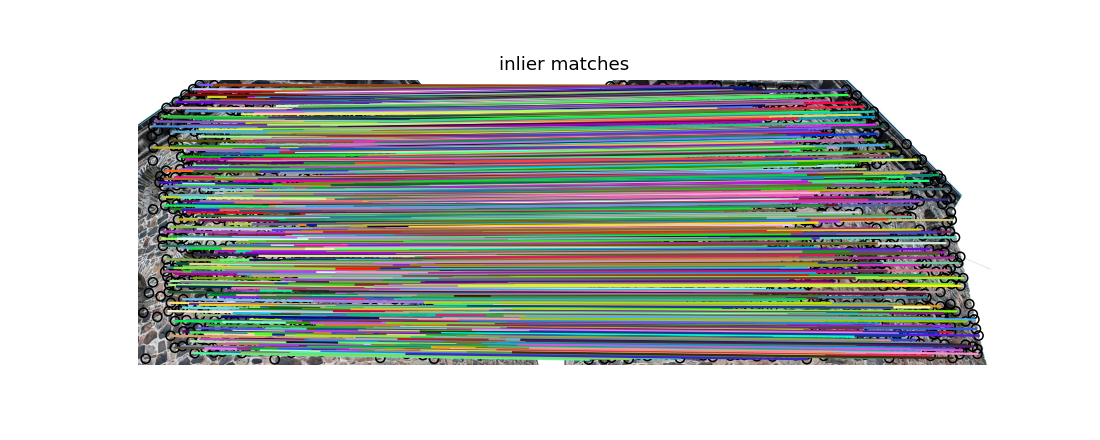

In [7]:
from numpy.linalg import inv
# normalization of points in two images using K (intrinsic parameters) e.g. in the following three steps
# a. convert original points to homogeneous 3-vectors (append "1" as a 3rd coordinate using np.append function)
tmp = np.ones((ptsR.shape[0],1))
ptsR_homo = np.append(ptsR,tmp,axis=1)
ptsL_homo = np.append(ptsL,tmp,axis=1)
n_ptsR = np.ones((ptsR_homo.shape[0],3))
n_ptsL = np.ones((ptsL_homo.shape[0],3))
#print(ptsR)
#print(ptsR_homo)


# b. transform the point by applying the inverse of K
for i in range(ptsR_homo.shape[0]):
    n_ptsR[i] = np.matmul(la.inv(K), ptsR_homo[i])
    n_ptsL[i] = np.matmul(la.inv(K), ptsL_homo[i])   
#print(n_ptsR)
    
# c. convert homogeneous 3-vectors to 2-vectors (in R2)
#print(n_ptsL)
n_ptsL = n_ptsL[:,:2]/n_ptsL[:,[-1]]
n_ptsR = n_ptsR[:,:2]/n_ptsR[:,[-1]]
#print(n_ptsL)
#print(n_ptsL.shape)

# robustly estimate essential matrix using normalized points and RANSAC
E_trans, E_inliers = ransac((n_ptsL, n_ptsR), EssentialMatrixTransform, min_samples=8, residual_threshold=0.0005, max_trials=5000)
num_inliers = np.sum(E_inliers)
print ('the number of inliers is {:2d}'.format(num_inliers))

ind = np.ogrid[:n_ptsL.shape[0]]
EmatchesRansac = np.column_stack((ind[E_inliers],ind[E_inliers]))

fig = plt.figure(5,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, EmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()


### singular values for E

In [8]:
E = E_trans.params
Ue,Se,Ve = la.svd(E)
print (Se)

[4.49400346e+00 4.38493189e+00 4.76456523e-16]


### Epipolar Lines from E 

<IPython.core.display.Javascript object>


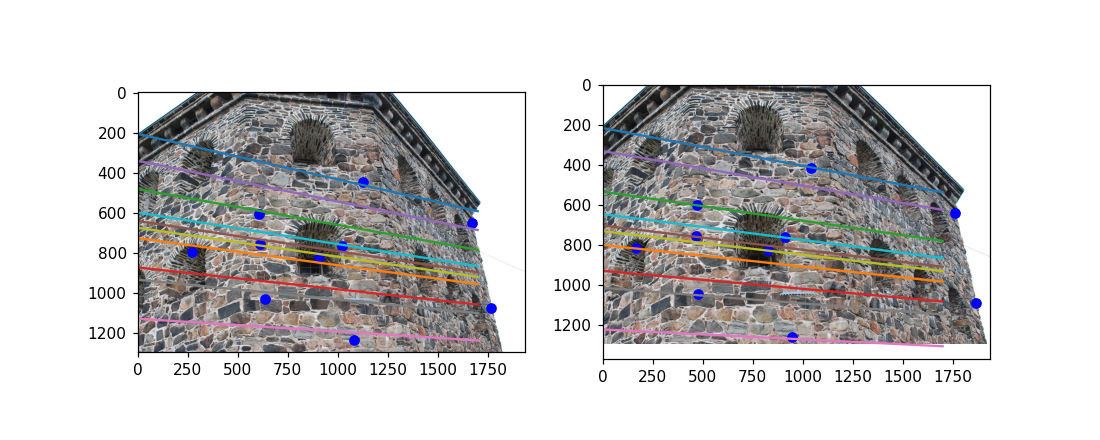

In [24]:
# Randomly select 10 matches (paris of features in two images) from the set of inliers for E
ind_sample = np.random.choice(ind[E_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(6,figsize = (10, 4))
ax61 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax62 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# generate epipolar line equations in image 2 (homoheneous 3-vectors l2 representing lines l2 x  = 0) 
# a. create an array of normalized points sampled in image 1 
nor_sample1 = n_ptsL[ind_sample,:]
nor_sample2 = n_ptsL[ind_sample,:]

# b. create an array of homogeneous normalized points sampled in image 1 
tmp = np.ones((nor_sample1.shape[0],1))
nor_sample1_homo = np.append(nor_sample1,tmp,axis=1)
nor_sample2_homo = np.append(nor_sample2,tmp,axis=1)

# c. create an array of the corresponding (uncalibrated) epipolar lines in image 2

elinesL = nor_sample2_homo @ E @ la.inv(K)

elinesR = nor_sample1_homo.copy()

for i in range(10):
    elinesR[i] = la.inv(K).T @ E  @ nor_sample1_homo[i]

# v = au+b
ab12 = np.ones((10,2))
ab11 = np.ones((10,2))
for i in range(10):
    ab11[i][0] = - elinesL[i][0] / elinesL[i][1]
    ab11[i][1] = - elinesL[i][2] / elinesL[i][1]
    ab12[i][0] = - elinesR[i][0] / elinesR[i][1]
    ab12[i][1] = - elinesR[i][2] / elinesR[i][1]


# for each feature (in both images) draw a correspoindiung epipolar line in the other image
# see Assignment 1 (line fitting part 1) for inspiration on how to visualize lines 

# n is the pair number
def predict1(x,n,mode): 
    if mode == 1:
        return ab11[n][0] * x + ab11[n][1] 
    elif mode == 2:
        return ab12[n][0] * x + ab12[n][1] 
    
x1 = np.arange(0,1700)
for i in range(10):
    y11 = predict1(x1,i,1)
    y12 = predict1(x1,i,2)
    ax61.plot(x1, y11)
    ax62.plot(x1, y12)


# for each feature (in both images) draw a correspoindiung epipolar line in the other image
# use ax61.plot and ax62.plot 

plt.show()

### Camera rotation and translation (four solutions)

#### Factorize essential matrix $E=[T]_x R$ where $R$ is rotation and $T$ is a translation. Find solutions $R_1$, $R_2$ and $T_1$, $T_2$. Use camera 1 for world coordinates. Define projection matrix for camera 1 as $P_w = [I|0]$ and compute four projection matrices for the second camera $P_a$, $P_b$, $P_c$, $P_d$.


In [25]:
Ue,Se,Ve = la.svd(E)

Se = np.diag(Se)
# if det(UV^T) = -1, switch the sign of the last column in V
if la.det(np.matmul(Ue, Ve.T)) < 0:
    #Ve[:,[2]] = -Ve[:,[2]]
    Ve[[2],:] = -Ve[[2],:]

# using special matrix W
W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
  
R1 = np.matmul(np.matmul(Ue, W),Ve)
R2 = np.matmul(np.matmul(Ue, W.T),Ve)
T1 = Ue[:,[2]]
T2 = -Ue[:,[2]]

# first camera matrix
Pw = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

# four possible matrices for the second camera
Pa = np.column_stack((R1,T1))
Pb = np.column_stack((R1,T2))
Pc = np.column_stack((R2,T1))
Pd = np.column_stack((R2,T2))


### Summary of Structure-from-Motion
#### In these 3D reconstruction steps you should use the world coordinate system consistent with the projection matrices estimated in step 7. In all steps you should obtain solutions for all four distinct cases of the second camera: $P_a$, $P_b$, $P_c$, $P_d$. First, we Implement least squares (you can use $svd$ or $inv$ functions) for "triangulating" 3D points corresponding to pairs of matched features that are inliers for estimated $E$ (i.e. consistent with the epipolar geometry). 
#### Then we compute camera positioning (optical centers and calibrated image centers as 3D points) in the world coordinate system. This is used in data visualsation step 10 (fully implemented). That step visulaizes in 3D both camera positions (red - optcal centers, green - image centers) and triangulated points (blue) for four possible cases of the second camera. We identify one case when solution has 3D points in front of both cameras. 
#### In the weproject 3D points onto each camera, convert to uncalibrated coordinates, and display these projected points (use red) together with the original features (use blue). Observe if the are red and blue points are close in each image.
### Step 8: Triangulation (four solutions)

In [26]:
# Select normalized coordinates for matched features that are inliers for essential matrix E. 
# Form matrix A in equation AX=0 where X represent 4 vectors (homogeneous representation of 3D point).
# Use your solution for Problem 6.
# Each camera (projection matrix P) will define its own A  
nor_L = n_ptsL[ind[E_inliers]]
nor_R = n_ptsR[ind[E_inliers]]

# Note that Pw is the first camera matrix
# two matched feature point is [u_a,v_a,1] and [u_b,v_b,1]
# From problem 6: we need to solve 
# (𝑃w[1]−𝑃w[3]⋅u_a)⋅𝑋=0
# (𝑃w[1]−𝑃w[3]⋅v_a)⋅𝑋=0
# (𝑃_abcd[1]−𝑃_abcd[3]⋅u_b)⋅𝑋=0
# (𝑃_abcd[1]−𝑃_abcd[3]⋅v_b)⋅𝑋=0


def compute_A(case, A):
    if case == 1:
        A[0] = Pw[[0],:] - nor_L[0][0] * Pw[[2],:]
        A[1] = Pw[[1],:] - nor_L[0][1] * Pw[[2],:]
        A[2] = Pa[[0],:] - nor_R[0][0] * Pa[[2],:]
        A[3] = Pa[[1],:] - nor_R[0][1] * Pa[[2],:]
    if case == 2:
        A[0] = Pw[[0],:] - nor_L[0][0] * Pw[[2],:]
        A[1] = Pw[[1],:] - nor_L[0][1] * Pw[[2],:]
        A[2] = Pb[[0],:] - nor_R[0][0] * Pb[[2],:]
        A[3] = Pb[[1],:] - nor_R[0][1] * Pb[[2],:]
    if case == 3:
        A[0] = Pw[[0],:] - nor_L[0][0] * Pw[[2],:]
        A[1] = Pw[[1],:] - nor_L[0][1] * Pw[[2],:]
        A[2] = Pc[[0],:] - nor_R[0][0] * Pc[[2],:]
        A[3] = Pc[[1],:] - nor_R[0][1] * Pc[[2],:]
    if case == 4:
        A[0] = Pw[[0],:] - nor_L[0][0] * Pw[[2],:]
        A[1] = Pw[[1],:] - nor_L[0][1] * Pw[[2],:]
        A[2] = Pd[[0],:] - nor_R[0][0] * Pd[[2],:]
        A[3] = Pd[[1],:] - nor_R[0][1] * Pd[[2],:]

Aa = np.ones((4,4))
compute_A(1, Aa)
#print(Aa)

Ab = np.ones((4,4))
compute_A(2, Ab)
#print(Ab)

Ac = np.ones((4,4))
compute_A(3, Ac)
#print(Ac)

Ad = np.ones((4,4))
compute_A(4, Ad)
#print(Ad)


#### Solution using least squares: assume homogeneous 3D point $X=[X_1,X_2,X_3,1]$. Then, $AX=0$ gives 4 equations for 3 unknowns. 

In [27]:
# least squares for solving linear system A_{0:2} X_{0:2} = - A_3 
Aa_02 =  Aa[:,:3]      # the first 3 columns of 4x4 matrix A
Aa_3  =  Aa[:,3]      # the last column on 3x4 matrix A
#print(Aa_02)
#print(Aa_3)

Ab_02 =  Ab[:,:3] 
Ab_3  =  Ab[:,3] 
Ac_02 =  Ac[:,:3]      
Ac_3  =  Ac[:,3] 
Ad_02 =  Ad[:,:3]      
Ad_3  =  Ad[:,3] 

def compute_one_XYZ(A_02, A_3):
    tmp1 = la.inv(np.matmul(A_02.T, A_02))
    tmp2 = np.matmul(tmp1, A_02.T)
    return np.matmul(tmp2, (-A_3))

def compute_all_XYZ(case, X):
    N = nor_L[:,0].size
    if case == 1:
        for i in range(N):
            A = np.ones((4,4))
            A[0] = Pw[[0],:] - nor_L[i][0] * Pw[[2],:]
            A[1] = Pw[[1],:] - nor_L[i][1] * Pw[[2],:]
            A[2] = Pa[[0],:] - nor_R[i][0] * Pa[[2],:]
            A[3] = Pa[[1],:] - nor_R[i][1] * Pa[[2],:]
            A_02 = A[:,:3]
            A_3  =  A[:,3] 
            X[i] = compute_one_XYZ(A_02, A_3)
    if case == 2:
        for i in range(N):
            A = np.ones((4,4))
            A[0] = Pw[[0],:] - nor_L[i][0] * Pw[[2],:]
            A[1] = Pw[[1],:] - nor_L[i][1] * Pw[[2],:]
            A[2] = Pb[[0],:] - nor_R[i][0] * Pb[[2],:]
            A[3] = Pb[[1],:] - nor_R[i][1] * Pb[[2],:]
            A_02 = A[:,:3]
            A_3  =  A[:,3] 
            X[i] = compute_one_XYZ(A_02, A_3)
    if case == 3:
        for i in range(N):
            A = np.ones((4,4))
            A[0] = Pw[[0],:] - nor_L[i][0] * Pw[[2],:]
            A[1] = Pw[[1],:] - nor_L[i][1] * Pw[[2],:]
            A[2] = Pc[[0],:] - nor_R[i][0] * Pc[[2],:]
            A[3] = Pc[[1],:] - nor_R[i][1] * Pc[[2],:]
            A_02 = A[:,:3]
            A_3  =  A[:,3] 
            X[i] = compute_one_XYZ(A_02, A_3)
    if case == 4:
        for i in range(N):
            A = np.ones((4,4))
            A[0] = Pw[[0],:] - nor_L[i][0] * Pw[[2],:]
            A[1] = Pw[[1],:] - nor_L[i][1] * Pw[[2],:]
            A[2] = Pd[[0],:] - nor_R[i][0] * Pd[[2],:]
            A[3] = Pd[[1],:] - nor_R[i][1] * Pd[[2],:]
            A_02 = A[:,:3]
            A_3  =  A[:,3] 
            X[i] = compute_one_XYZ(A_02, A_3)
    

# Nx3 matrices: N rows with 3D point coordinates for N reconstructed points (N=num_inliers)

N = nor_L[:,0].size
Xa = np.ones((N,3))
compute_all_XYZ(1, Xa)
#print(Xa)

Xb = np.ones((N,3))
compute_all_XYZ(2, Xb)
#print(Xb)

Xc = np.ones((N,3))
compute_all_XYZ(3, Xc)
#print(Xc)

Xd = np.ones((N,3))
compute_all_XYZ(4, Xd)
#print(Xd)



### Camera positioning in 3D  (four solutions)
#### In this step we compute location of each cameras' optical center and its (calibrated) image center as points in 3D (world coordinate system).

In [28]:
# camera's optical centers (for pair of cameras) as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D point coordinates for the first and second camera
Ca = np.zeros((2,3))
Cb = np.zeros((2,3))
Cc = np.zeros((2,3))
Cd = np.zeros((2,3))


Ca[1] = np.matmul(la.inv(R1), -T1).T
Cb[1] = np.matmul(la.inv(R1), -T2).T
Cc[1] = np.matmul(la.inv(R2), -T1).T
Cd[1] = np.matmul(la.inv(R2), -T2).T


# calibrated/normalized image centers (for pair of cameras) as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D po### Step 9: Cameras positions/orientations in 3D  (four solutions)int coordinates for the first and second camera
Qa = np.zeros((2,3))
Qb = np.zeros((2,3))
Qc = np.zeros((2,3))
Qd = np.zeros((2,3))

zero_one = np.zeros((3,1))
zero_one[2][0] = 1

Qa[0][2] = 1
Qb[0][2] = 1
Qc[0][2] = 1
Qd[0][2] = 1

Qa[1] = np.matmul(la.inv(R1),zero_one - T1).T

Qb[1] = np.matmul(la.inv(R1),zero_one - T2).T
Qc[1] = np.matmul(la.inv(R2),zero_one - T1).T
Qd[1] = np.matmul(la.inv(R2),zero_one - T2).T



print (Cc)
print (Qc)

[[ 0.          0.          0.        ]
 [-0.88007371 -0.16064416 -0.44683746]]
[[ 0.          0.          1.        ]
 [-0.15713693 -0.03574591 -1.12636879]]


### 3D visualization of cameras and triangulated points (four solutions)

<IPython.core.display.Javascript object>


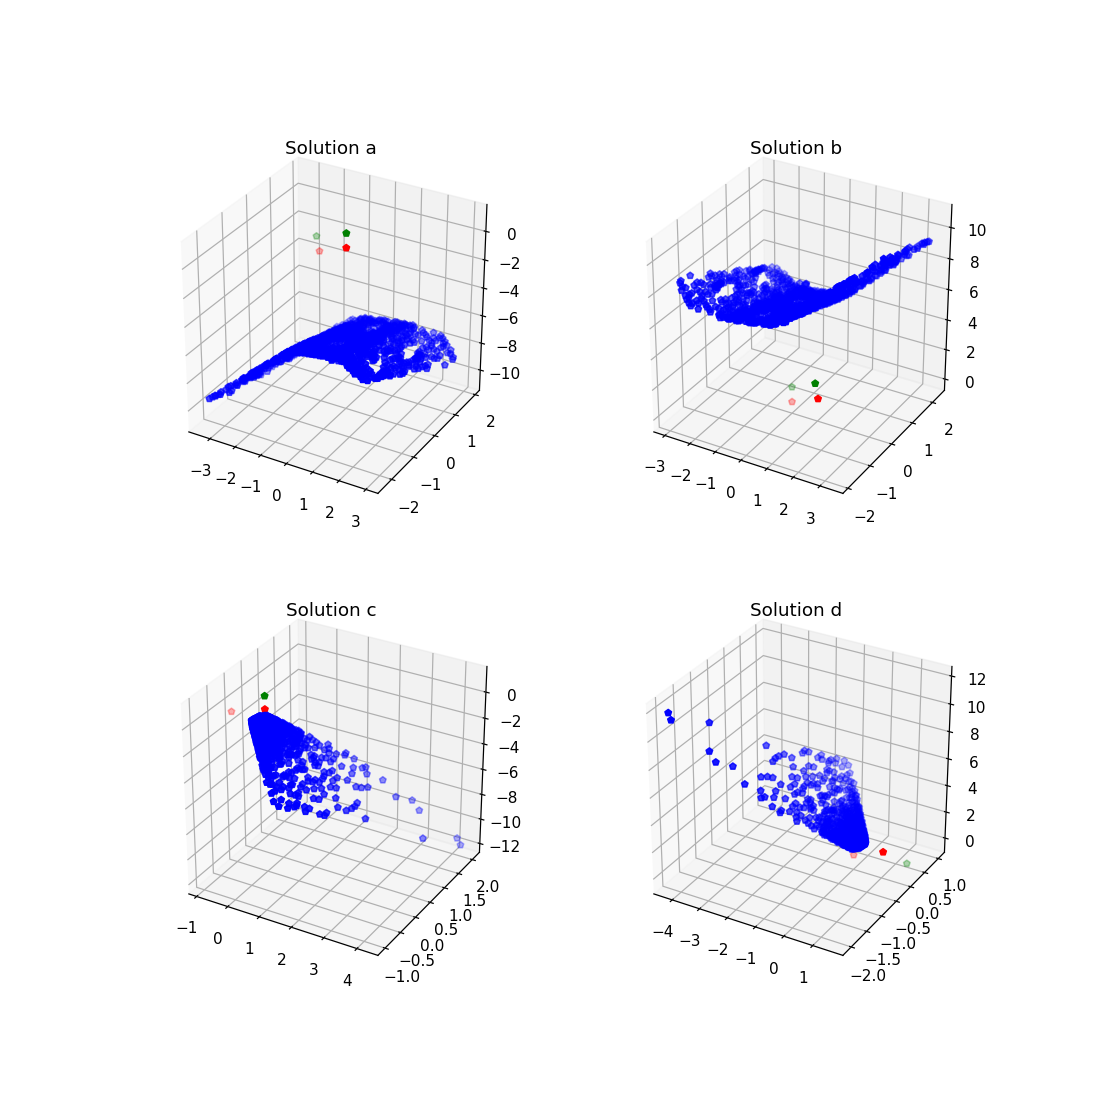

In [29]:
# visualization part
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(10,figsize = (10, 10))

ax10_1 = plt.subplot(221, projection='3d')
plt.title('Solution a')
ax10_1.scatter(Xa[:,0],Xa[:,1],Xa[:,2], c='b', marker='p')
ax10_1.scatter(Ca[:,0],Ca[:,1],Ca[:,2], c='r', marker='p')
ax10_1.scatter(Qa[:,0],Qa[:,1],Qa[:,2], c='g', marker='p')

ax10_2 = plt.subplot(222, projection='3d')
plt.title('Solution b')
ax10_2.scatter(Xb[:,0],Xb[:,1],Xb[:,2], c='b', marker='p')
ax10_2.scatter(Cb[:,0],Cb[:,1],Cb[:,2], c='r', marker='p')
ax10_2.scatter(Qb[:,0],Qb[:,1],Qb[:,2], c='g', marker='p')

ax10_3 = plt.subplot(223, projection='3d')
plt.title('Solution c')
ax10_3.scatter(Xc[:,0],Xc[:,1],Xc[:,2], c='b', marker='p')
ax10_3.scatter(Cc[:,0],Cc[:,1],Cc[:,2], c='r', marker='p')
ax10_3.scatter(Qc[:,0],Qc[:,1],Qc[:,2], c='g', marker='p')

ax10_4 = plt.subplot(224, projection='3d')
plt.title('Solution d')
ax10_4.scatter(Xd[:,0],Xd[:,1],Xd[:,2], c='b', marker='p')
ax10_4.scatter(Cd[:,0],Cd[:,1],Cd[:,2], c='r', marker='p')
ax10_4.scatter(Qd[:,0],Qd[:,1],Qd[:,2], c='g', marker='p')

plt.show()

### Reprojection errors

<IPython.core.display.Javascript object>


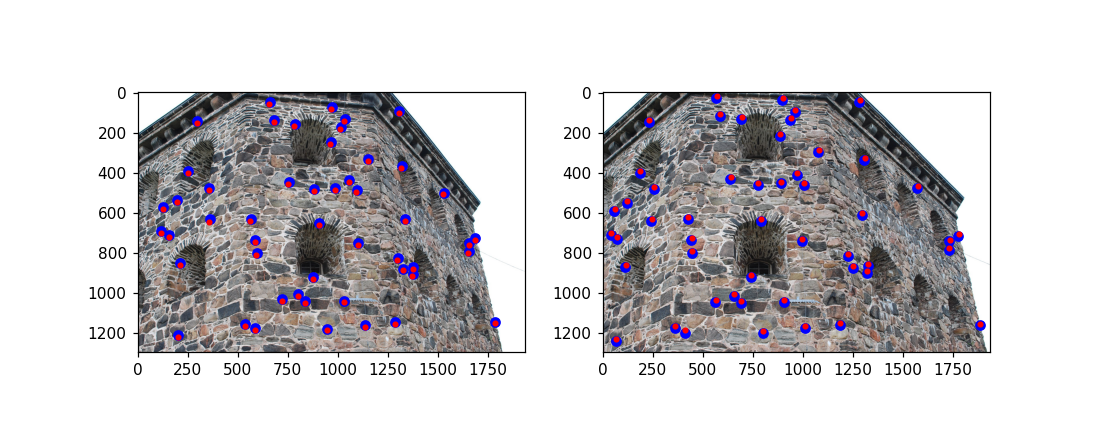

In [30]:
# Randomly select N=50 matches (pairs of features in two images) from the set of inliers for E
N = 50
ind_sample2 = np.random.choice(num_inliers, N, replace = False)

# Indicate (E) inlier matches in image 1 and image 2
plt.figure(11,figsize = (10, 4))
ax11_1 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax11_2 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')

# project reconstructed 3D points onto both images and display them in red color
# a. convert correct points (Xa, Xb, Xc, or Xd) to homogeneous 4 vectors
tmp = np.ones((50,1))
Xa_homo = np.append(Xa[ind_sample2],tmp,axis=1)
Xb_homo = np.append(Xb[ind_sample2],tmp,axis=1)
Xc_homo = np.append(Xc[ind_sample2],tmp,axis=1)
Xd_homo = np.append(Xd[ind_sample2],tmp,axis=1)


# b. project homogeneous 3D points (onto uncalibrated cameras) using correct Projection matrices (KPw and, e.g. KPa)
Kpw = np.matmul(K, Pw)
Kpa = np.matmul(K, Pa)
Kpb = np.matmul(K, Pb)
Kpc = np.matmul(K, Pc)
Kpd = np.matmul(K, Pd)

proj_homoR = np.ones((N,3))
proj_homoL = np.ones((N,3))
for i in range(N):
    proj_homoR[i] = np.matmul(Kpd,Xd_homo[i])
    proj_homoL[i] = np.matmul(Kpw,Xd_homo[i])

# c. convert to regular (inhomogeneous) point
ptsL_proj = np.zeros((N,2))
ptsR_proj = np.zeros((N,2))


ptsR_proj = proj_homoR[:,:2]/ proj_homoR[:,[-1]] 
ptsL_proj = proj_homoL[:,:2]/ proj_homoL[:,[-1]] 



ax11_1.plot(ptsL_proj[:,0], ptsL_proj[:,1], '.r')
ax11_2.plot(ptsR_proj[:,0], ptsR_proj[:,1], '.r')

plt.show()

#### The difference of 4 solutions

<IPython.core.display.Javascript object>


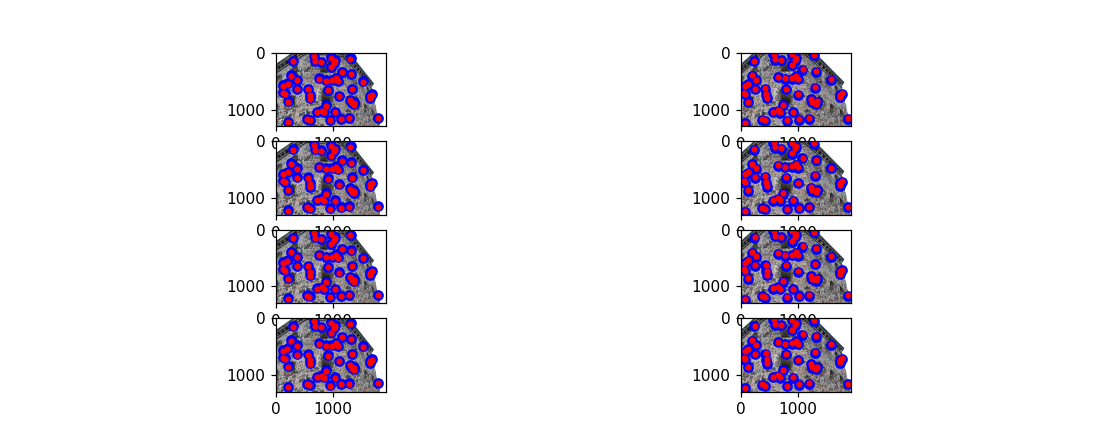

In [49]:
plt.figure(12,figsize = (10, 4))

# using b
ax01_1 = plt.subplot(421)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax01_2 = plt.subplot(422)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')
# using b
ax02_1 = plt.subplot(423)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax02_2 = plt.subplot(424)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')
# using c
ax03_1 = plt.subplot(425)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax03_2 = plt.subplot(426)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')
# using d
ax04_1 = plt.subplot(427)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax04_2 = plt.subplot(428)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')

proj_homoR1 = np.ones((N,3))
proj_homoL1 = np.ones((N,3))
proj_homoR2 = np.ones((N,3))
proj_homoL2 = np.ones((N,3))
proj_homoR3 = np.ones((N,3))
proj_homoL3 = np.ones((N,3))
proj_homoR4 = np.ones((N,3))
proj_homoL4 = np.ones((N,3))
for i in range(N):
    proj_homoR1[i] = np.matmul(Kpa,Xa_homo[i])
    proj_homoL1[i] = np.matmul(Kpw,Xa_homo[i])
    proj_homoR2[i] = np.matmul(Kpb,Xb_homo[i])
    proj_homoL2[i] = np.matmul(Kpw,Xb_homo[i])
    proj_homoR3[i] = np.matmul(Kpc,Xc_homo[i])
    proj_homoL3[i] = np.matmul(Kpw,Xc_homo[i])
    proj_homoR4[i] = np.matmul(Kpd,Xd_homo[i])
    proj_homoL4[i] = np.matmul(Kpw,Xd_homo[i])

# c. convert to regular (inhomogeneous) point
ptsL_proj1 = np.zeros((N,2))
ptsR_proj1 = np.zeros((N,2))
ptsL_proj2 = np.zeros((N,2))
ptsR_proj2 = np.zeros((N,2))
ptsL_proj3 = np.zeros((N,2))
ptsR_proj3 = np.zeros((N,2))
ptsL_proj4 = np.zeros((N,2))
ptsR_proj4 = np.zeros((N,2))


ptsR_proj1 = proj_homoR1[:,:2]/ proj_homoR1[:,[-1]] 
ptsL_proj1 = proj_homoL1[:,:2]/ proj_homoL1[:,[-1]] 
ptsR_proj2 = proj_homoR2[:,:2]/ proj_homoR2[:,[-1]] 
ptsL_proj2 = proj_homoL2[:,:2]/ proj_homoL2[:,[-1]]
ptsR_proj3 = proj_homoR3[:,:2]/ proj_homoR3[:,[-1]] 
ptsL_proj3 = proj_homoL3[:,:2]/ proj_homoL3[:,[-1]]
ptsR_proj4 = proj_homoR4[:,:2]/ proj_homoR4[:,[-1]] 
ptsL_proj4 = proj_homoL4[:,:2]/ proj_homoL4[:,[-1]]



ax01_1.plot(ptsL_proj1[:,0], ptsL_proj1[:,1], '.r')
ax01_2.plot(ptsR_proj1[:,0], ptsR_proj1[:,1], '.r')
ax02_1.plot(ptsL_proj2[:,0], ptsL_proj2[:,1], '.r')
ax02_2.plot(ptsR_proj2[:,0], ptsR_proj2[:,1], '.r')
ax03_1.plot(ptsL_proj3[:,0], ptsL_proj3[:,1], '.r')
ax03_2.plot(ptsR_proj3[:,0], ptsR_proj3[:,1], '.r')
ax04_1.plot(ptsL_proj4[:,0], ptsL_proj4[:,1], '.r')
ax04_2.plot(ptsR_proj4[:,0], ptsR_proj4[:,1], '.r')
plt.show()